# Greedy K-Centers

This notebook provides the implementation and some test environment for the greedy k-centers algorithm for datapoint coreset selection.

Relevant literature:
- [https://openreview.net/pdf?id=H1aIuk-RW](https://openreview.net/pdf?id=H1aIuk-RW)
- [https://arxiv.org/pdf/1906.11829.pdf](https://arxiv.org/pdf/1906.11829.pdf)

# Algorithm implementation

Taken from the repository [https://github.com/stanford-futuredata/selection-via-proxy](https://github.com/stanford-futuredata/selection-via-proxy)

In [1]:
%%writefile greedy_k_center.py
import numpy as np
import scipy.spatial.distance
from tqdm import tqdm

def k_center_greedy(X, s, b):
    '''
    Args
    - X: np.array, shape [n, d]
    - s: list of int, indices of X that have already been selected
    - b: int, new selection budget

    Returns: np.array, shape [b], type int64, newly selected indices
    '''
    n = X.shape[0]
    p = np.setdiff1d(np.arange(n), s, assume_unique=True)  # pool indices
    sel = np.empty(b, dtype=np.int64)

    sl = len(s)
    D = np.zeros([sl + b, len(p)], dtype=np.float32)
    D[:sl] = scipy.spatial.distance.cdist(X[s], X[p], metric='euclidean')  # shape (|s|,|p|)
    mins = np.min(D[:sl], axis=0)  # vector of length |p|
    cols = np.ones(len(p), dtype=bool)  # columns still in use

    for i in tqdm(range(b), desc="Greedy k-Centers"):
        j = np.argmax(mins)
        u = p[j]
        sel[i] = u

        if i == b - 1:
            break

        mins[j] = -1
        cols[j] = False

        # compute dist between selected point and remaining pool points
        r = sl + i + 1
        D[r, cols] = scipy.spatial.distance.cdist(X[u:u+1], X[p[cols]])[0]
        mins = np.minimum(mins, D[r])

    return sel

def k_center_greedy_slow(X, s0, b):
    '''
    @param X: [n, d] dataset, n datapoints with d features
    @param s0: list of indices, existing pool of center points
    @param b: budget
    @return: list of indices, new k-center points (not in s0) of size b
    '''
    n = X.shape[0]
    
    #get indices of remaining datapoints (not in s)
    rem = np.setdiff1d(np.arange(n), s, assume_unique=True).tolist()
    
    #choose random first datapoint if s is empty
    if len(s0) == 0:
        s0 = [np.random.randint(0, n)]
    
    sel = list(s0)

    # add center points until budget is exhausted
    for i in range(b):
        D = scipy.spatial.distance.cdist(X[sel], X[rem], metric='euclidean')  # shape (|s|,|p|)
        
        #search item with largest distance to all centers,
        #this becomes a new center point
        j = np.argmax(np.min(D, axis=0))
        u = rem[j]
        sel.append(u)
        rem.pop(j)

    #return s\s0 centers
    return np.asarray(sel[-b:])

Overwriting greedy_k_center.py


# Testing

Some tests for the implementation to play around with

Greedy k-Centers:   0%|          | 0/10 [00:00<?, ?it/s]


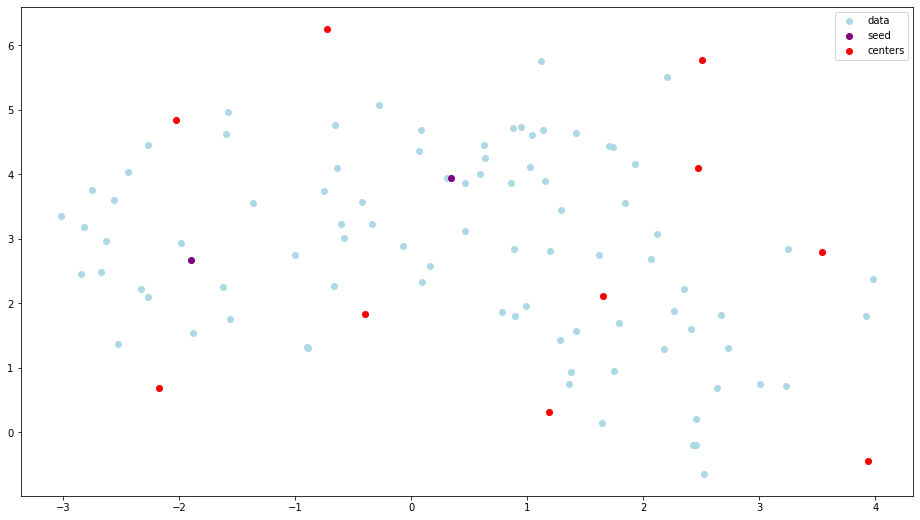

In [18]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
from greedy_k_center import k_center_greedy
import numpy as np

X, y = make_blobs(n_samples=100, random_state=0)

seedsize = 2
budget = 10
# get seed of random indices of X
seed = np.random.permutation(np.arange(0, len(X)))[:seedsize]

centers = k_center_greedy(X=X, s=seed, b=budget)

plt.figure(figsize=(16, 9))
plt.scatter(X[:,0], X[:,1], c='lightblue', label='data')
plt.scatter(X[seed,0], X[seed,1], c='purple', label='seed')
plt.scatter(X[centers,0], X[centers,1], c='red', label='centers')

plt.legend();